# Recurrent Neural Network Parameter Exploration
using multiple full flights to train


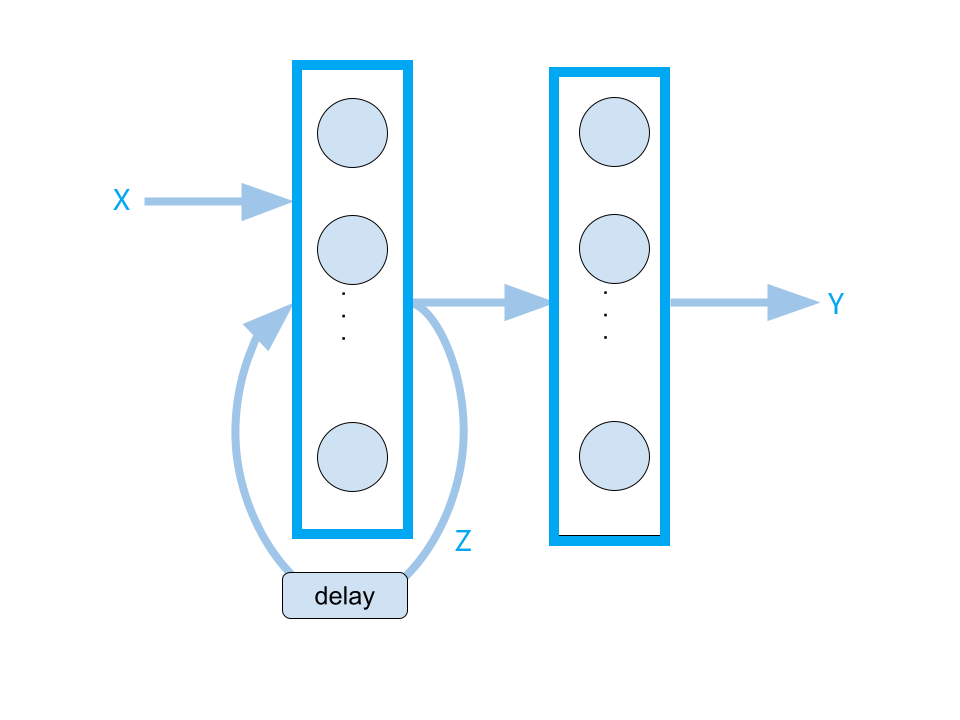

__Note:__<br>
Functions and methodology derived from assignments and lectures in the Fall '21
Colorado State University ML545 course taught by Dr. Chuck Anderson as well as the 
[Time Series Prediction with LSTM Using PyTorch](https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=vIWvJCpOVmwUresearch)
on google colab.  

# General Flow of this algorithm

1. Read in the parquet data
2. Filter the unnecessary columns of data out (may not need this)
3. Convert data to numpy arrays
4. Create a sliding window pair of X & T
4. Create Training, Validation, and Testing datasets for bootstrapping
5. Normalize Training dataset
6. Initialize the RNN
7. Train the RNN
8. Find the "best" parameters based on using Validation set compared to model
8. Look at confusion matrix results to "tune" these parameters
9. Measure the performance of the "best" parameter model using Test set 
10. look at confusion matrix results for test performance.

## Definition of variables  
(quantities listed for single Tail_687_1 flight data file)<br>
Tail_687_1_parquet/687200104111158.mat<br>

    N number of samples (in time)  (125303 time samples at 16hz, lower for other frequencies) 
    S number of samples per sequence (how long to make each sequence? 1-3secs? 32 frames at 16hz?)
    I number of components in each sample (188 variables in parquet file, but narrowed down to 26)
    H number of units in hidden recurrent layer
    O number of units in linear output layer

    X:  N x S x I
    Vx: I x H   Vz: H x H    Vb: 1 x H
    Z:  N x S+1 X H
    Wz: H x 0   Wb: 1 x O
    Y:  N x O
    T:  N x O  

    Dy: N x O   Dz:  N x H
    Gvx:  N x I x H    Gvz:  N x H x H    Gvb:  N x H
    Gwz:  N x H x O    Gwb:  N x O

## Data translation
this uses nasa_data_funcs_v3.py written from another jupyter notebook

## Model definition
This uses the LSTM.py written from another jupyter notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import time
%matplotlib inline
#from IPython.display import display, clear_output

import LSTM as ml
import nasa_data_funcs_v6 as ndf  #v4 removes the VRTG, LONG, LATG

In [3]:
#querying the GPU attributes and processes
!nvidia-smi

Wed Jul 20 18:13:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 32%   29C    P8    24W / 350W |     16MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:21:00.0 Off |                  N/A |
| 40%   

In [4]:
#This is for rock, paper, and scissors (*.cs.colostate.edu) that have 4 CUDA devices (GPUs)
# look at the output from the nvidia-smi and only make the devices available that are not being used.
!CUDA_VISIBLE_DEVICES=0,1,2,3
print(f'Total Number of CUDA Devices: {torch.cuda.device_count()}')

Total Number of CUDA Devices: 4


In [5]:
#looking for a GPU if available to run faster than a cpu
# good documentation: 
# https://pytorch.org/docs/master/notes/cuda.html
# https://pytorch.org/docs/master/cuda.html#module-torch.cuda

if torch.cuda.is_available():
    cuda0 = torch.device('cuda:0')
    cuda1 = torch.device('cuda:1')
    cuda2 = torch.device('cuda:2')
    cuda3 = torch.device('cuda:3')
    device = cuda0
else:
    device = torch.device('cpu')

torch.cuda.set_device(device)
    
device_properties = torch.cuda.get_device_properties(device)

print(f'Current CUDA Device: GPU{torch.cuda.current_device()} --> {torch.cuda.get_device_name()}\n')
print(f'Device Properties:\n  {device_properties}')
device.type

Current CUDA Device: GPU0 --> NVIDIA GeForce RTX 3090

Device Properties:
  _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24265MB, multi_processor_count=82)


'cuda'

## Setting up the Data and NN configs


In [6]:

debug=False  #set this up so i can run a smaller set when debugging

rand=False #random set of files from the fdir vs fixed set of files.

cwd = os.getcwd()

#this directory is currently hard-coded in (I know, Not great), so that means this python
# jupyter notebook needs to be run in the same directory as the data
fdir = 'Tail_687_1_parquet'
base_name = f'RecurrentNeuralNetwork_rand-multiflight_loop_baseline_batch_newParams2-3_update'
#data rate
frequency = 16

if debug:
    #testing configs
    # number of loops through random data
    n_rand_loops = 2
    restart = 0
    n_files  = 3  #needs to be at least 3 files here  
    batch_size = 50000  #average flight is about 125,000 samples

    #each config to go through the random loops
    seq_lengths     = [8,     8    ]   
    l_rates         = [0.005, 0.003 ] 
    epochs          = [150,  150 ] 
    n_h_units       = [10,   10   ]   
    n_h_layers      = [1,    1    ]    
    

else:

    # number of loops through random data
    n_rand_loops = 3 
    restart = 1 #this was built so i could restart a set of configs if something went wrong
    n_files = 20 #needs to be at least 3 files here  
    batch_size = 50000  #average flight is about 125,000 samples
    

 

    #seq_lengths     = [4,      4,      4,      8,      8,      8,      16,     16,     16]   
    #l_rates         = [0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007] 
    #epochs          = [3500,   3500,   3500,   3500,   3500,   3500,   3500,   3500,   3500] 
    #n_h_units       = [5,      10,     15,     10,     15,     20,     10,     15,     20]   
    #n_h_layers      = [1,      1,      1,      1,      1,      1,      1,      1,      1]   
    
    # seq_lengths     = [4,      8,      8,      8]   
    # l_rates         = [0.0007, 0.0007, 0.0007, 0.0007] 
    # epochs          = [3500,   3500,   3500,   3500] 
    # n_h_units       = [15,     10,     15,     20]   
    # n_h_layers      = [1,      1,      1,      1]   
    
    seq_lengths     = [8,     16,    4,      4,      16,     8,      4]   
    l_rates         = [0.003, 0.003, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007] 
    epochs          = [1800,  1800,  3500,   3500,   3500,   3500,   3500] 
    n_h_units       = [25,    10,    10,     20,     20,     25,     25]   
    n_h_layers      = [1,     1,     1,      1,      1,      1,      1]  


#choose to look at random files in the directory or a set number
# the set list is for comparing different methods for now.

if rand:
    os.chdir(os.path.join(cwd,fdir))
    fulllist = glob.glob(f'*.parquet')
    os.chdir(cwd)
    
else:
    #created this option since there were some "bad" files that were throwing off good
    # analysis.  plus this is easier to see and ensure I don't get duplicate files
    
    fulllist    =  ["687200107192334.parquet", 
                    "687200107301239.parquet",
                    "687200104261527.parquet",
                    "687200107251002.parquet",
                    "687200104301119.parquet",
                    "687200107101600.parquet",
                    "687200104170717.parquet",
                    "687200107181544.parquet",
                    "687200104202027.parquet",
                    "687200107170234.parquet",
                    "687200107251652.parquet",
                    "687200107122323.parquet",
                    "687200104162039.parquet",
                    "687200107311025.parquet",
                    "687200104181334.parquet",
                    "687200107171131.parquet",
                    "687200104181127.parquet",
                    "687200107241524.parquet",
                    "687200107060930.parquet",
                    "687200107150546.parquet"]
    

np.random.shuffle(fulllist)
#randomize the starting and run through all files eventually

file_list = fulllist[:n_files]


All configurations trained and tested on "n_files".
These files were randomly selected and this process was repeated for each configuration
3 times with the MSE being averaged over this repeated set training models.



----------------------
Configuration #1
----------------------
seq_length:16
learning_rate:0.003
n_epochs:1800
hidden_units:10
n_hidden_layers:1
n_bootloops:3
n_files:20
-----------------
Best Bootloop model: RecurrentNeuralNetwork_rand-multiflight_loop_baseline_batch_newParams2-3_update_config1_bootloop2.pt
MSE: 2.231138751085382e-05
---------------


Average Training Error: 0.000005906
Average Testing Error: 0.000057621


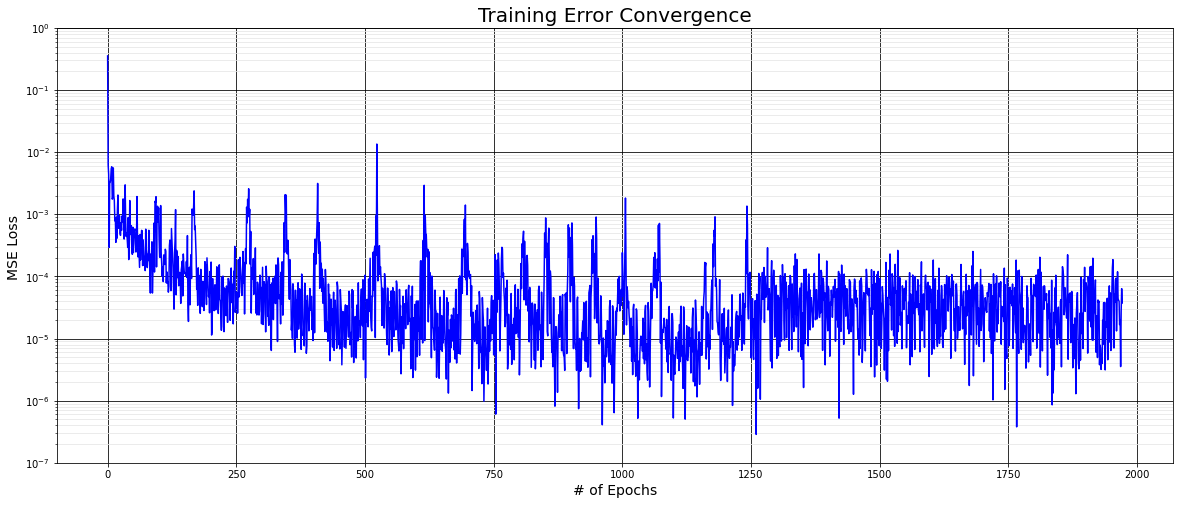

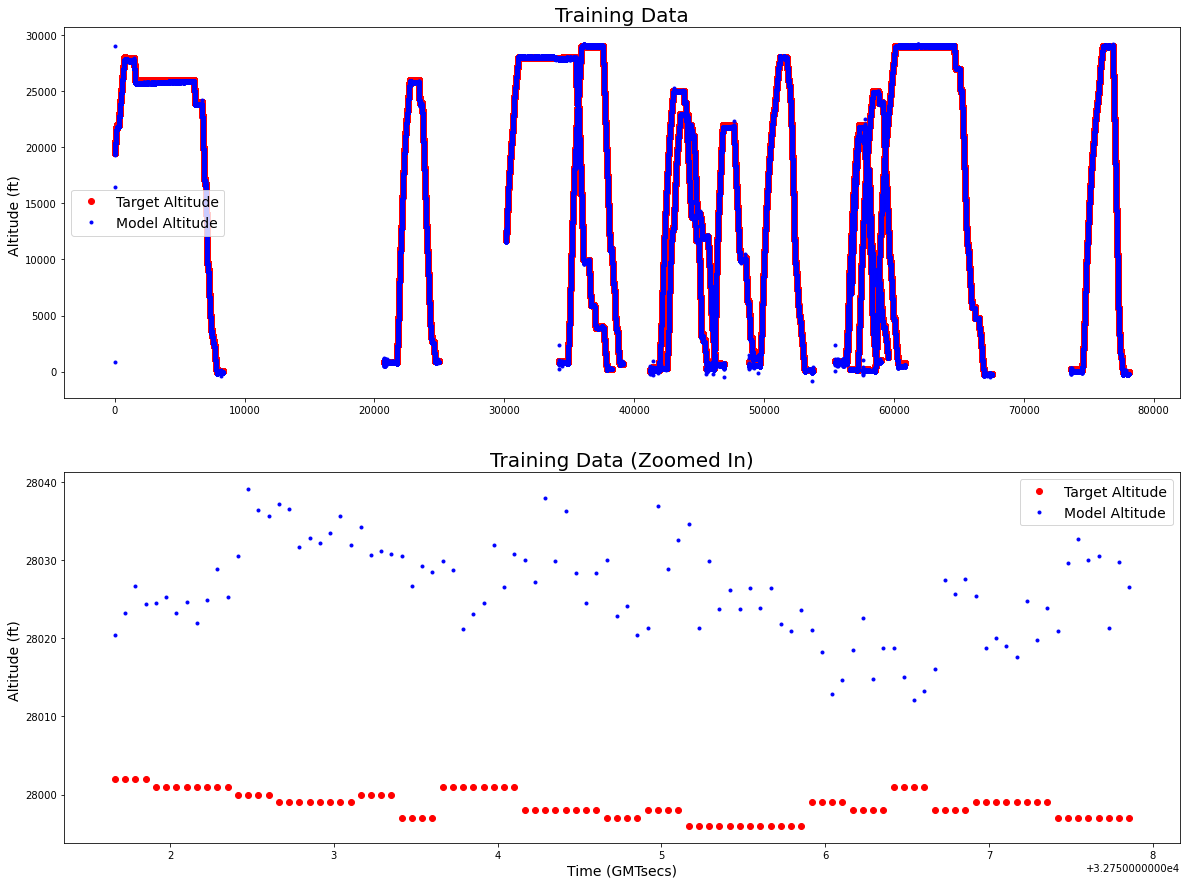

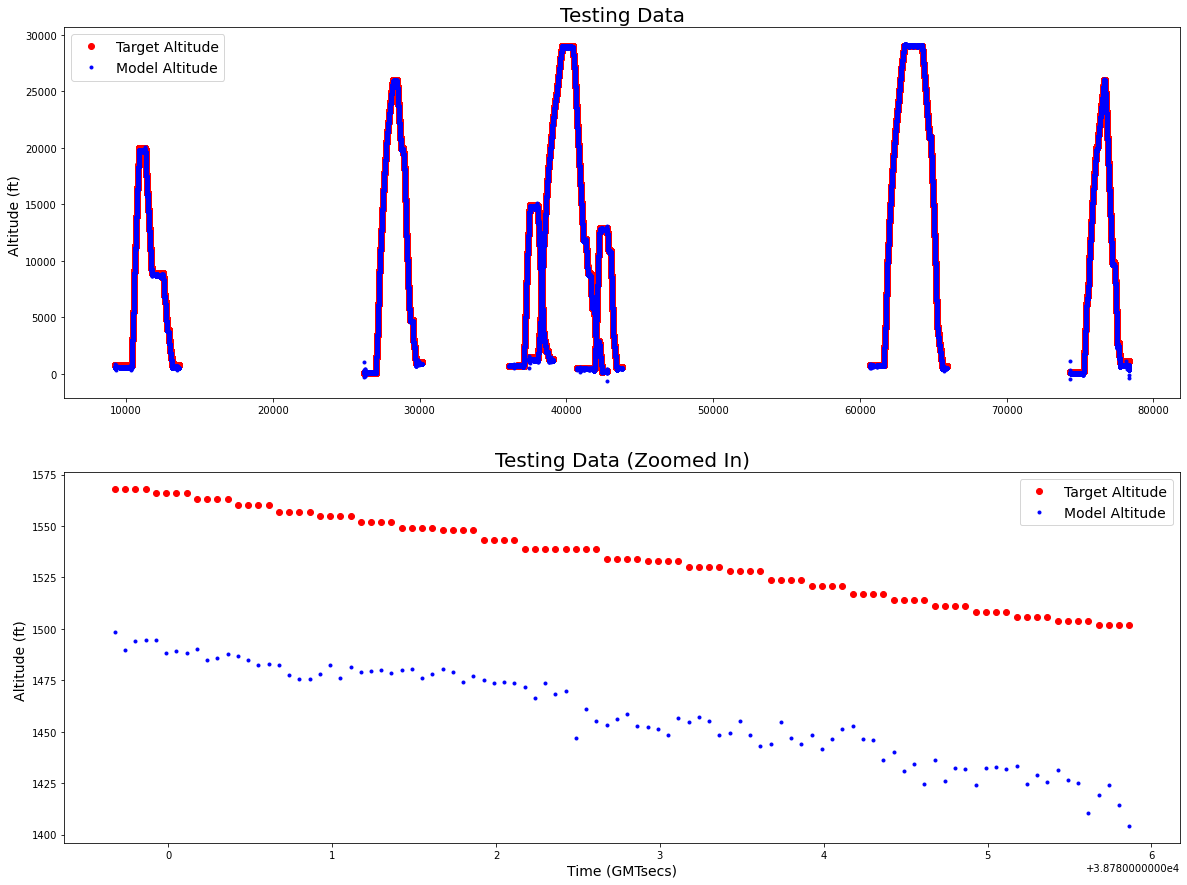




----------------------
Configuration #2
----------------------
seq_length:4
learning_rate:0.0007
n_epochs:3500
hidden_units:10
n_hidden_layers:1
n_bootloops:3
n_files:20
-----------------
Best Bootloop model: RecurrentNeuralNetwork_rand-multiflight_loop_baseline_batch_newParams2-3_update_config2_bootloop2.pt
MSE: 9.004502317111474e-06
---------------


Average Training Error: 0.000008306
Average Testing Error: 0.000010777


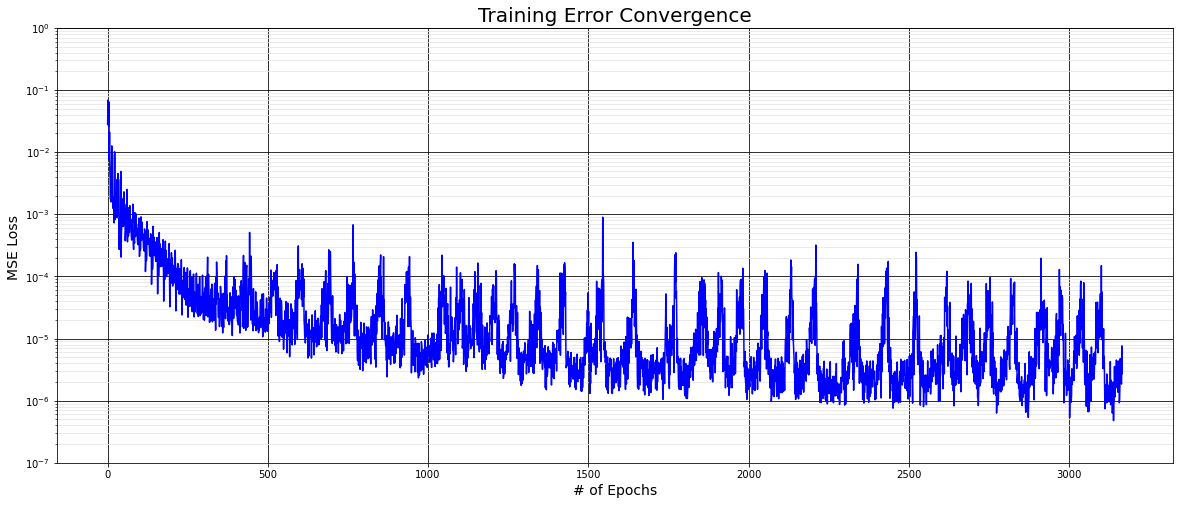

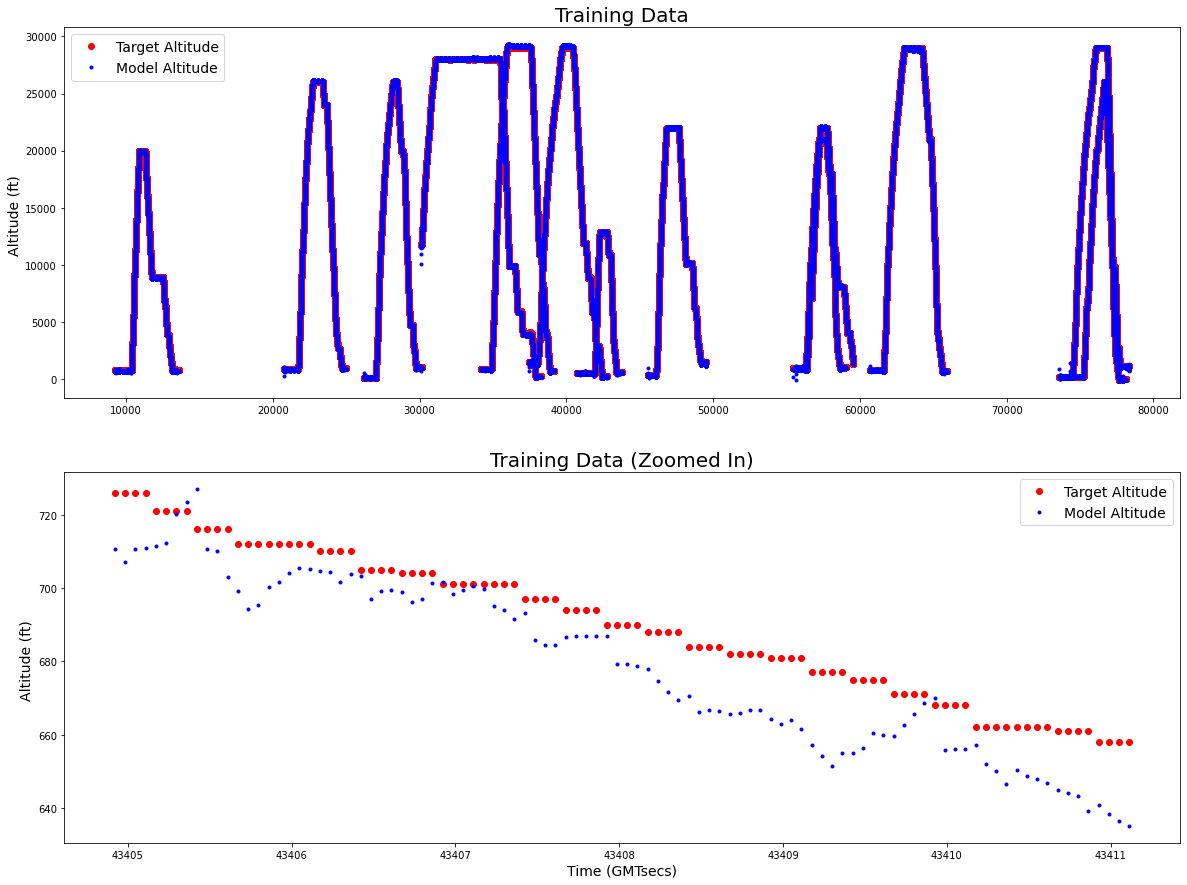

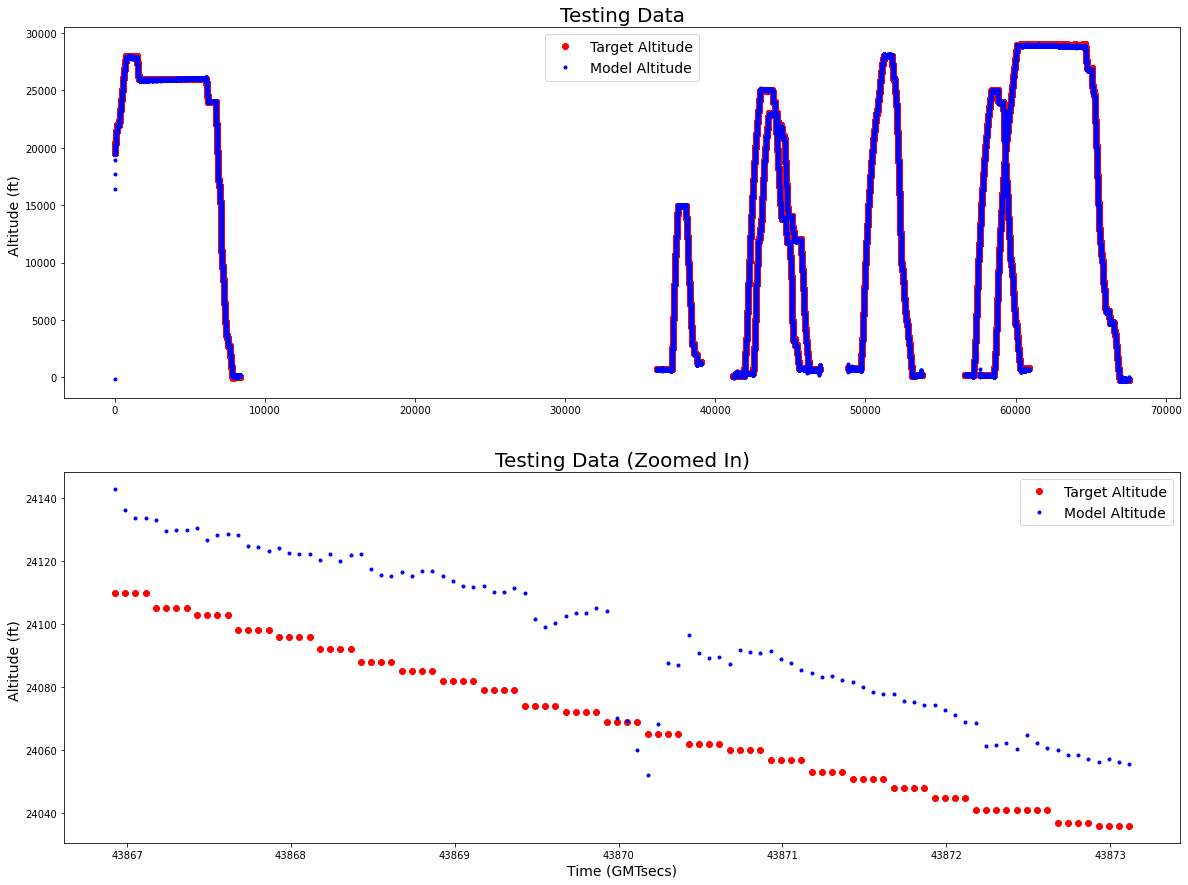




----------------------
Configuration #3
----------------------
seq_length:4
learning_rate:0.0007
n_epochs:3500
hidden_units:20
n_hidden_layers:1
n_bootloops:3
n_files:20
-----------------
Best Bootloop model: RecurrentNeuralNetwork_rand-multiflight_loop_baseline_batch_newParams2-3_update_config3_bootloop2.pt
MSE: 2.6002765025623376e-06
---------------


Average Training Error: 0.000004543
Average Testing Error: 0.000108883


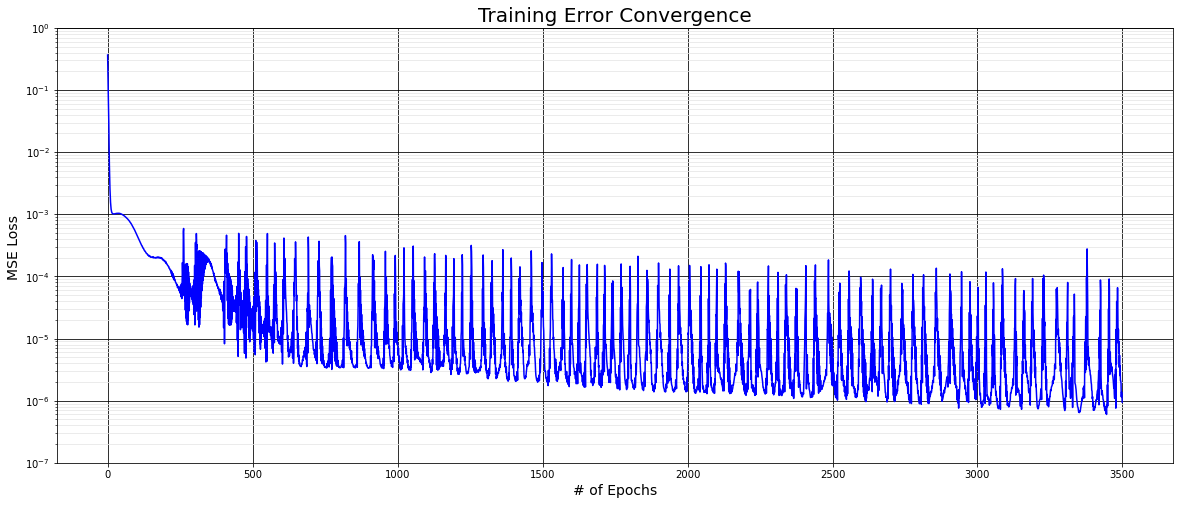

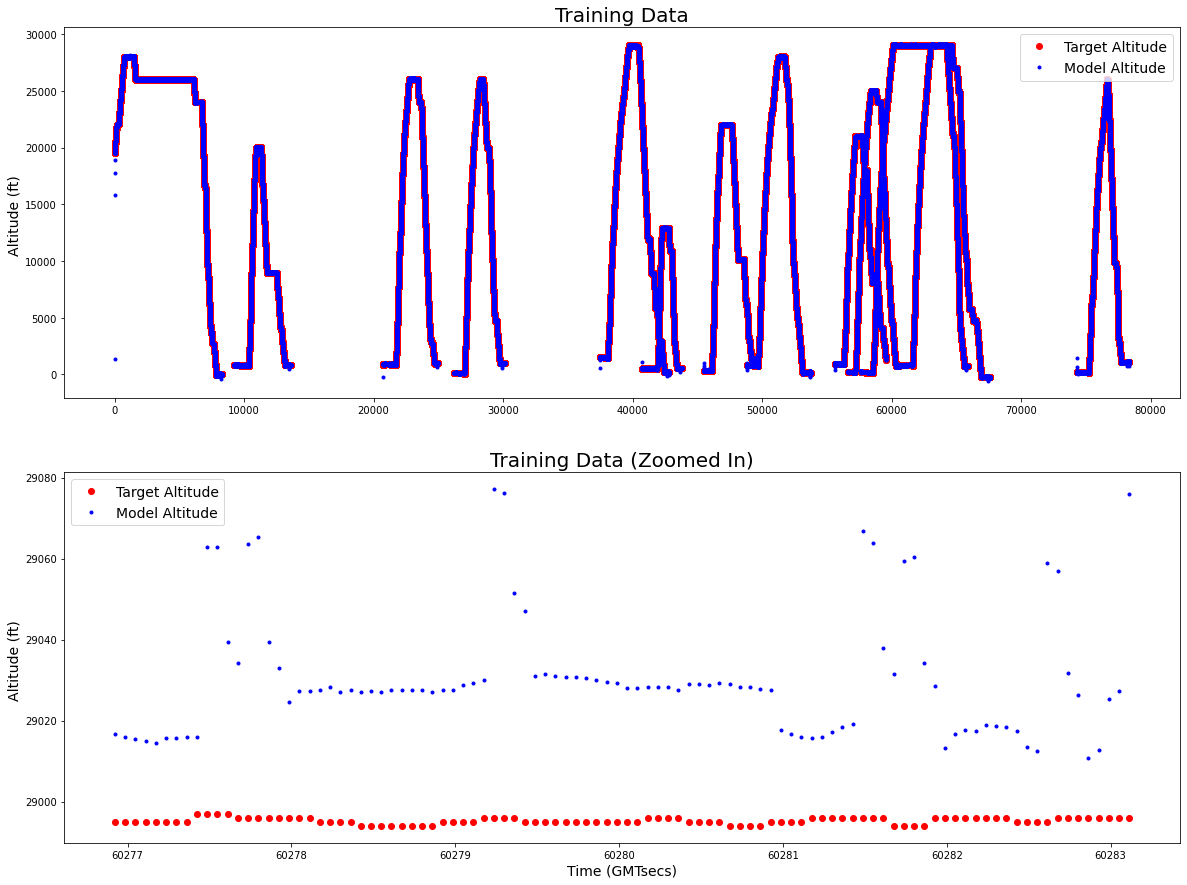

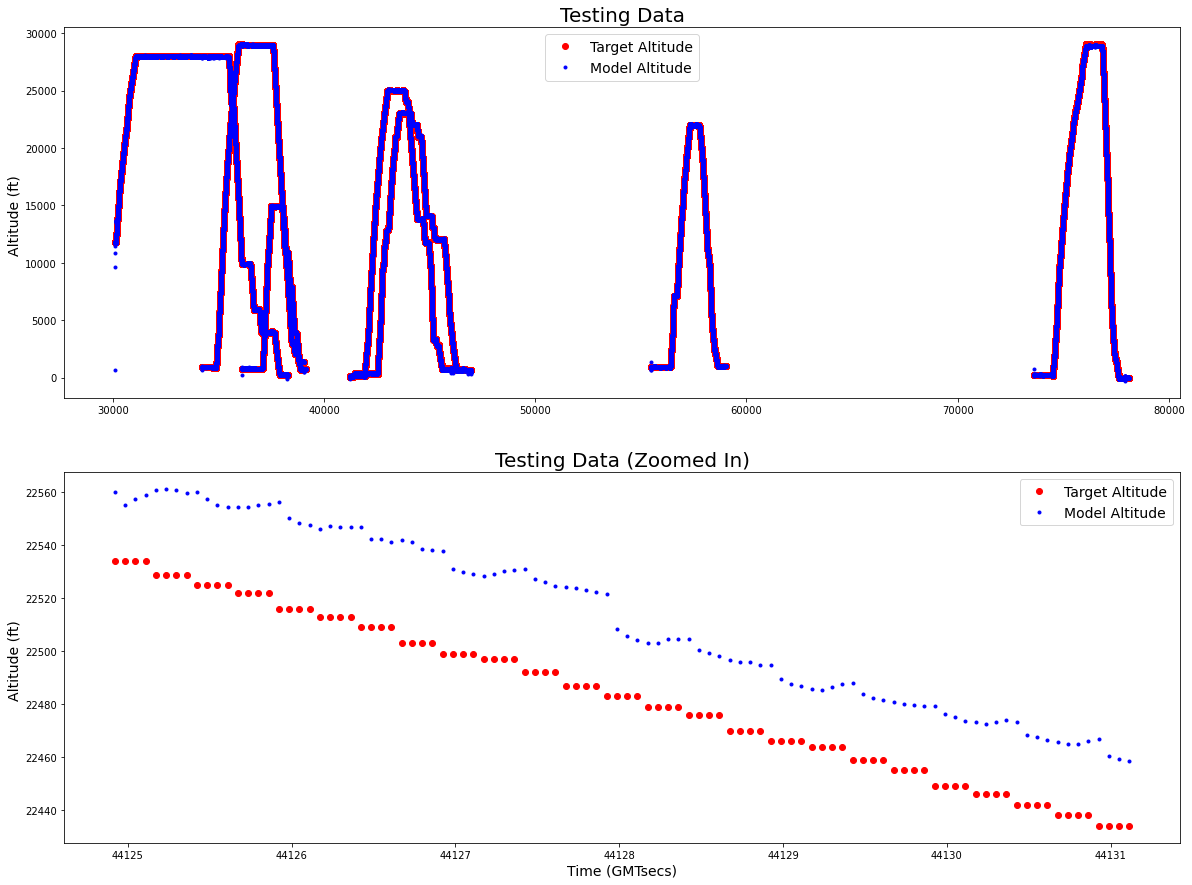




----------------------
Configuration #4
----------------------
seq_length:16
learning_rate:0.0007
n_epochs:3500
hidden_units:20
n_hidden_layers:1
n_bootloops:3
n_files:20
-----------------
Best Bootloop model: RecurrentNeuralNetwork_rand-multiflight_loop_baseline_batch_newParams2-3_update_config4_bootloop2.pt
MSE: 4.725770850200206e-06
---------------


Average Training Error: 0.000002441
Average Testing Error: 0.000007585


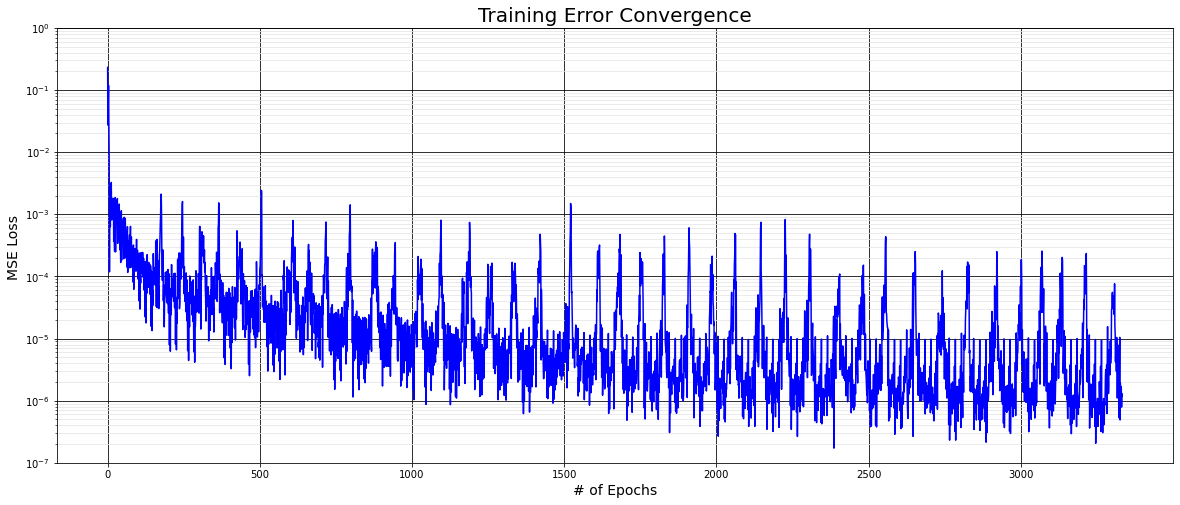

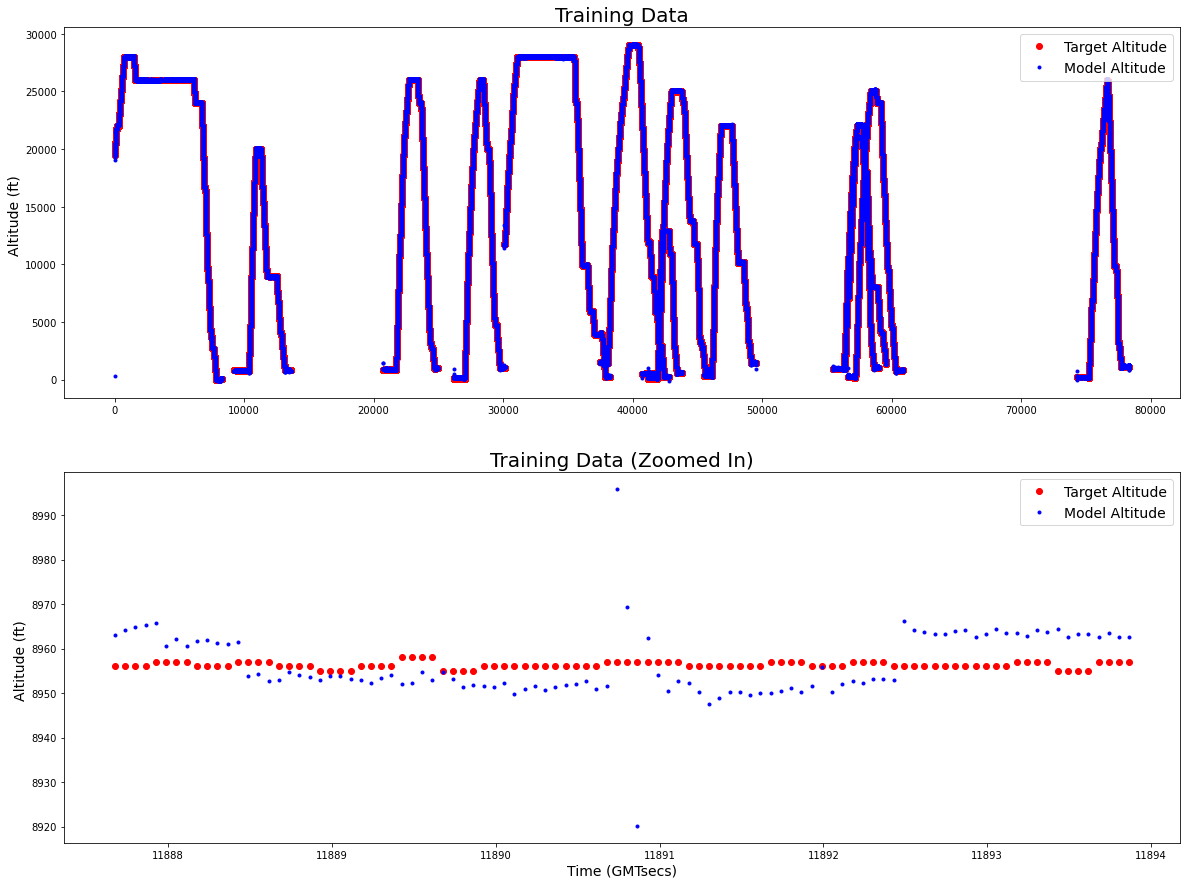

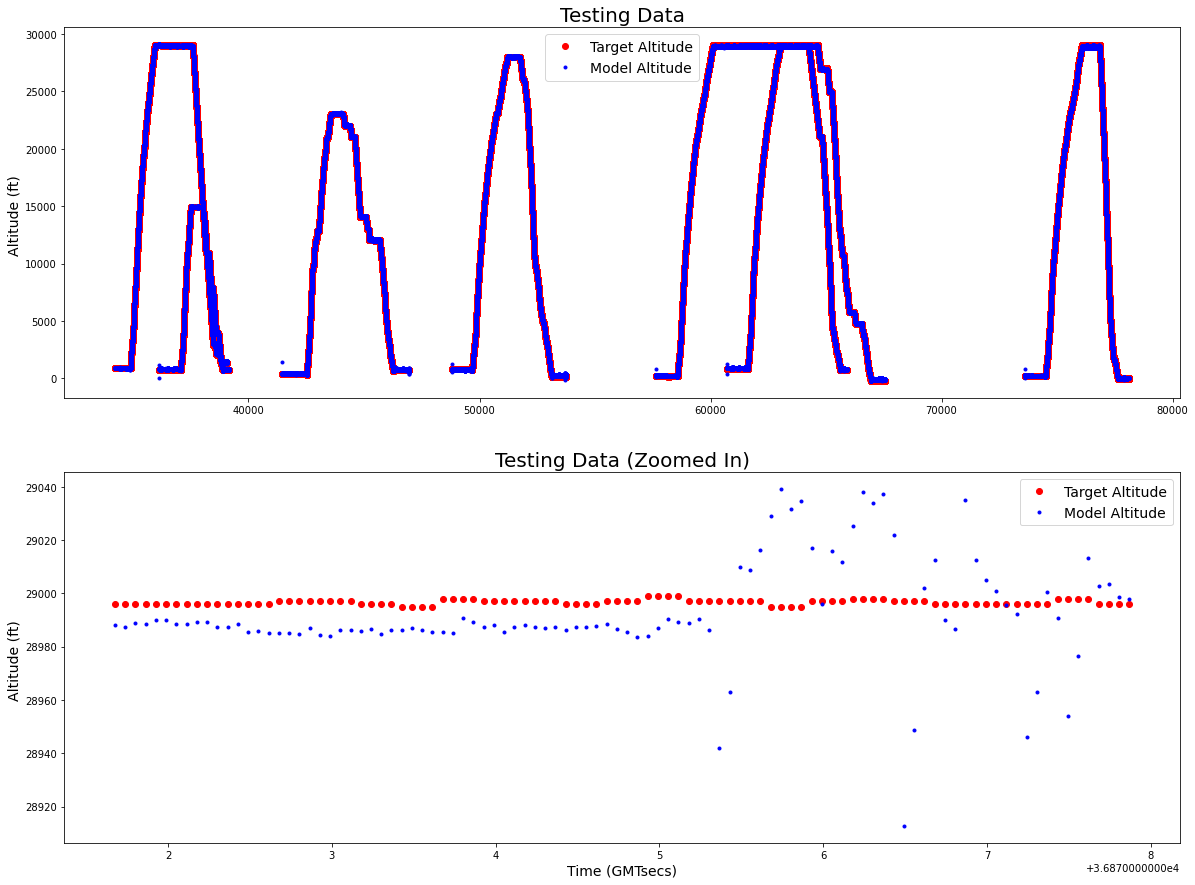




----------------------
Configuration #5
----------------------
seq_length:8
learning_rate:0.0007
n_epochs:3500
hidden_units:25
n_hidden_layers:1
n_bootloops:3
n_files:20
-----------------
Best Bootloop model: RecurrentNeuralNetwork_rand-multiflight_loop_baseline_batch_newParams2-3_update_config5_bootloop2.pt
MSE: 1.2518369658209849e-05
---------------


Average Training Error: 0.000001299
Average Testing Error: 0.000006564


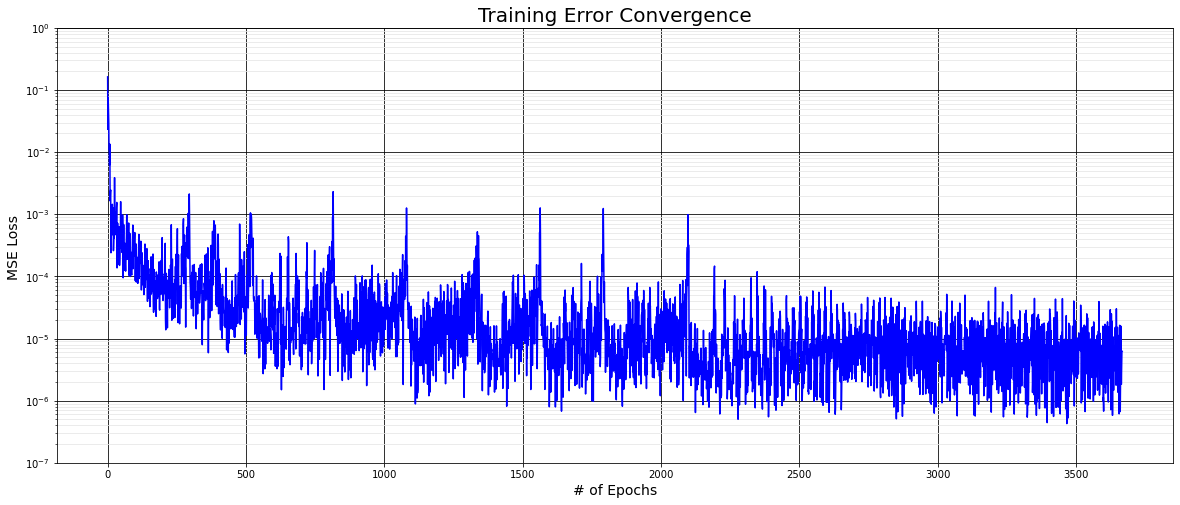

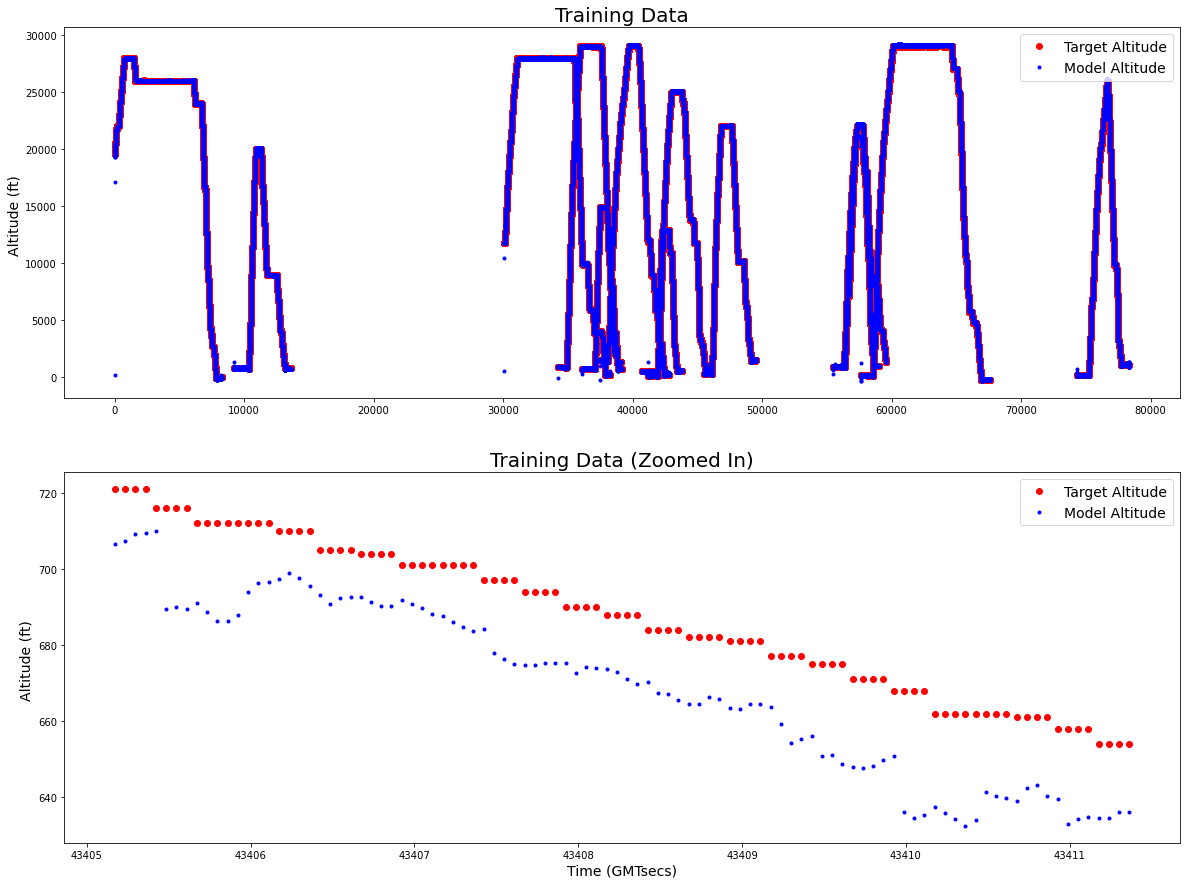

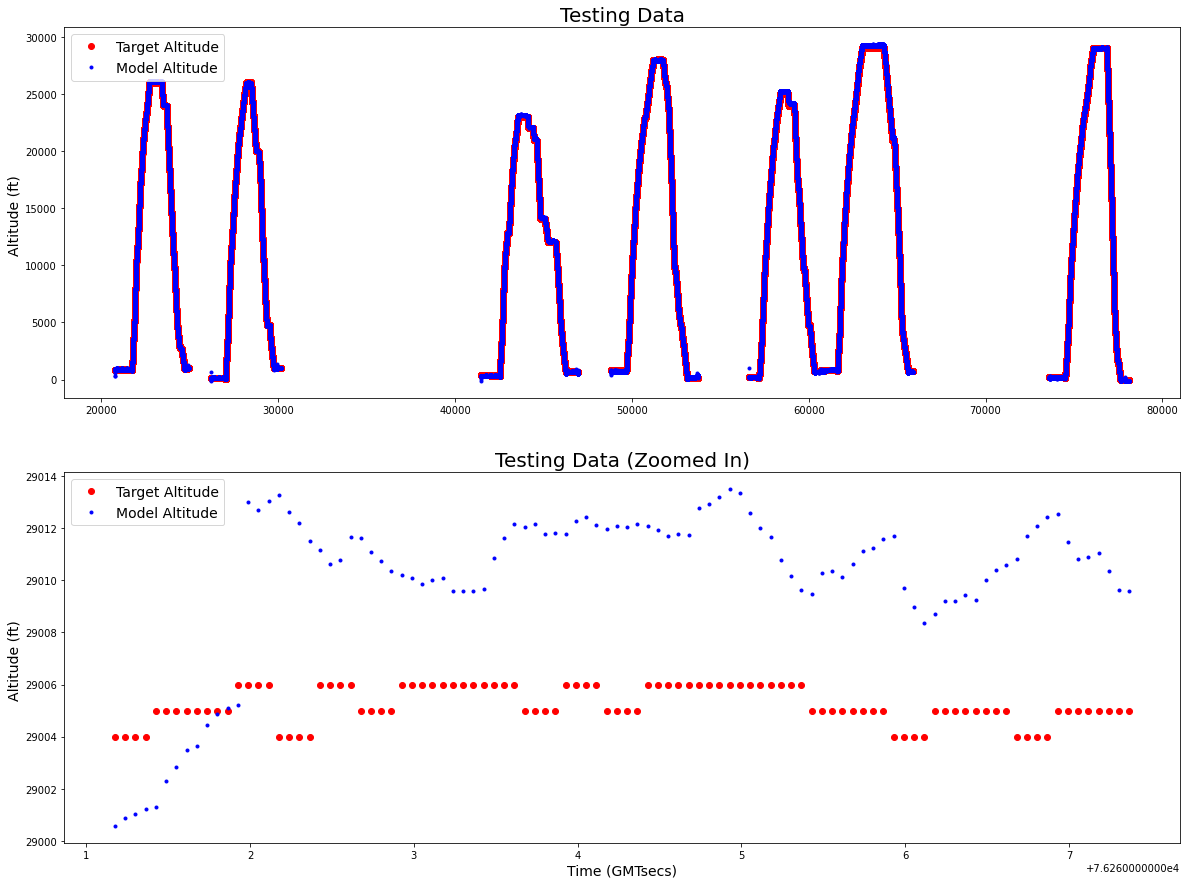




----------------------
Configuration #6
----------------------
seq_length:4
learning_rate:0.0007
n_epochs:3500
hidden_units:25
n_hidden_layers:1
n_bootloops:3
n_files:20
-----------------
Best Bootloop model: RecurrentNeuralNetwork_rand-multiflight_loop_baseline_batch_newParams2-3_update_config6_bootloop2.pt
MSE: 5.071428404335165e-06
---------------


Average Training Error: 0.000004262
Average Testing Error: 0.000006698


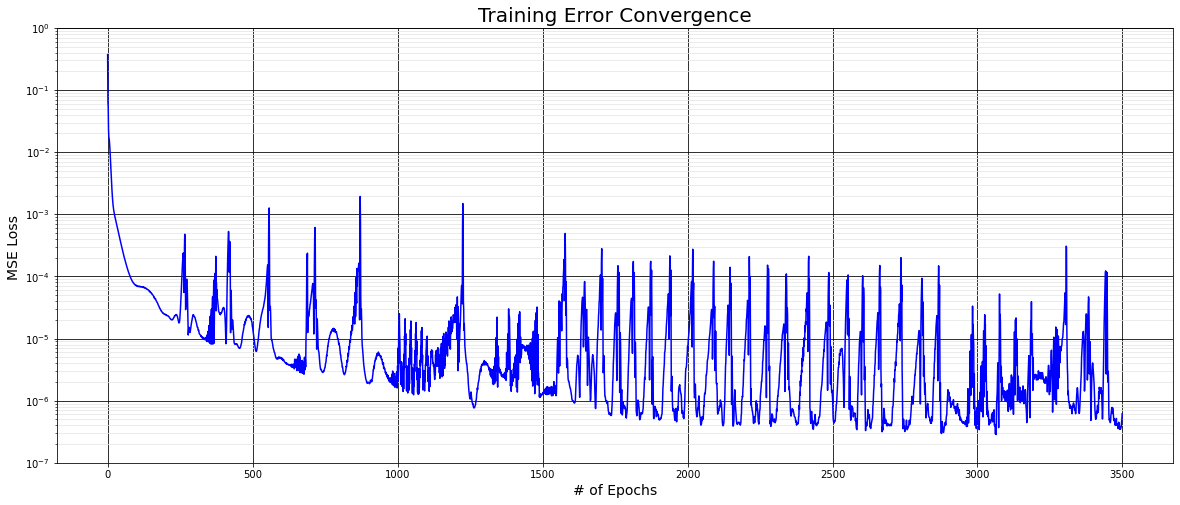

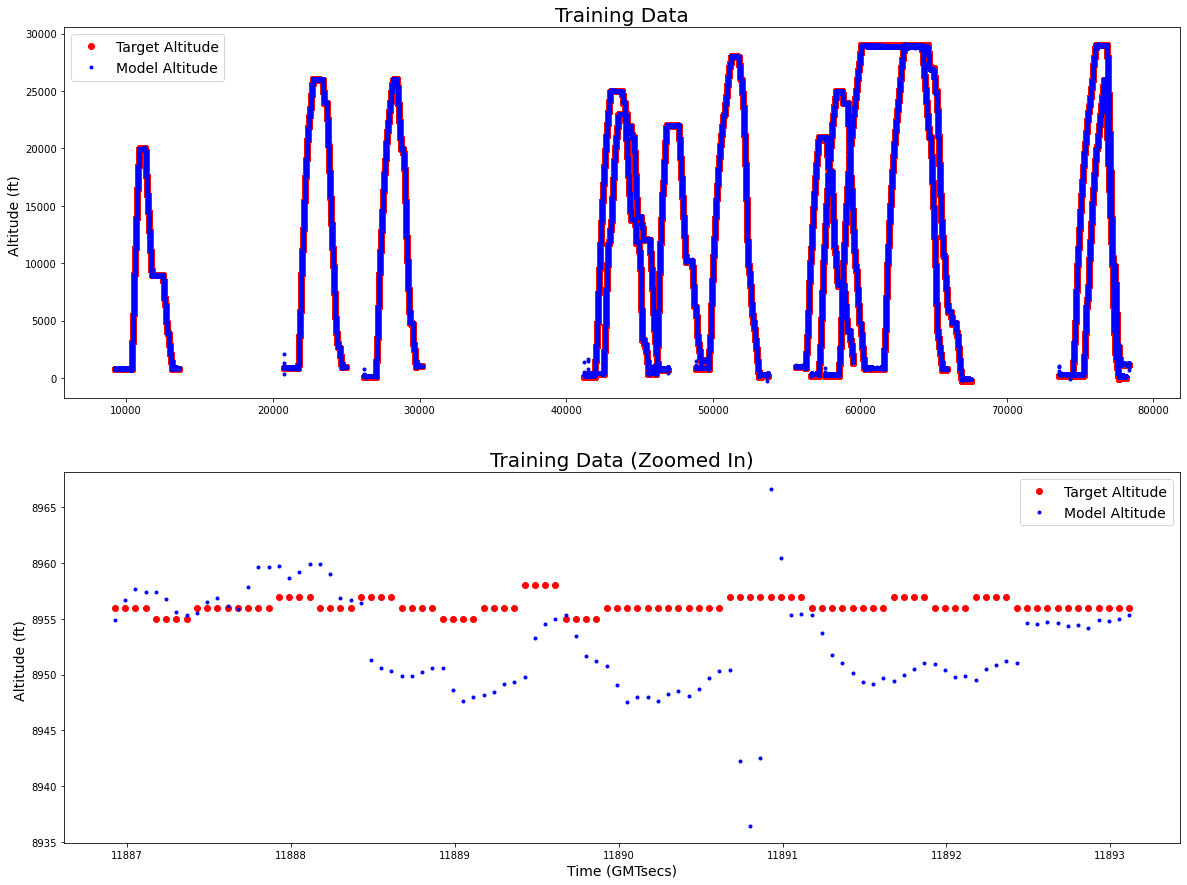

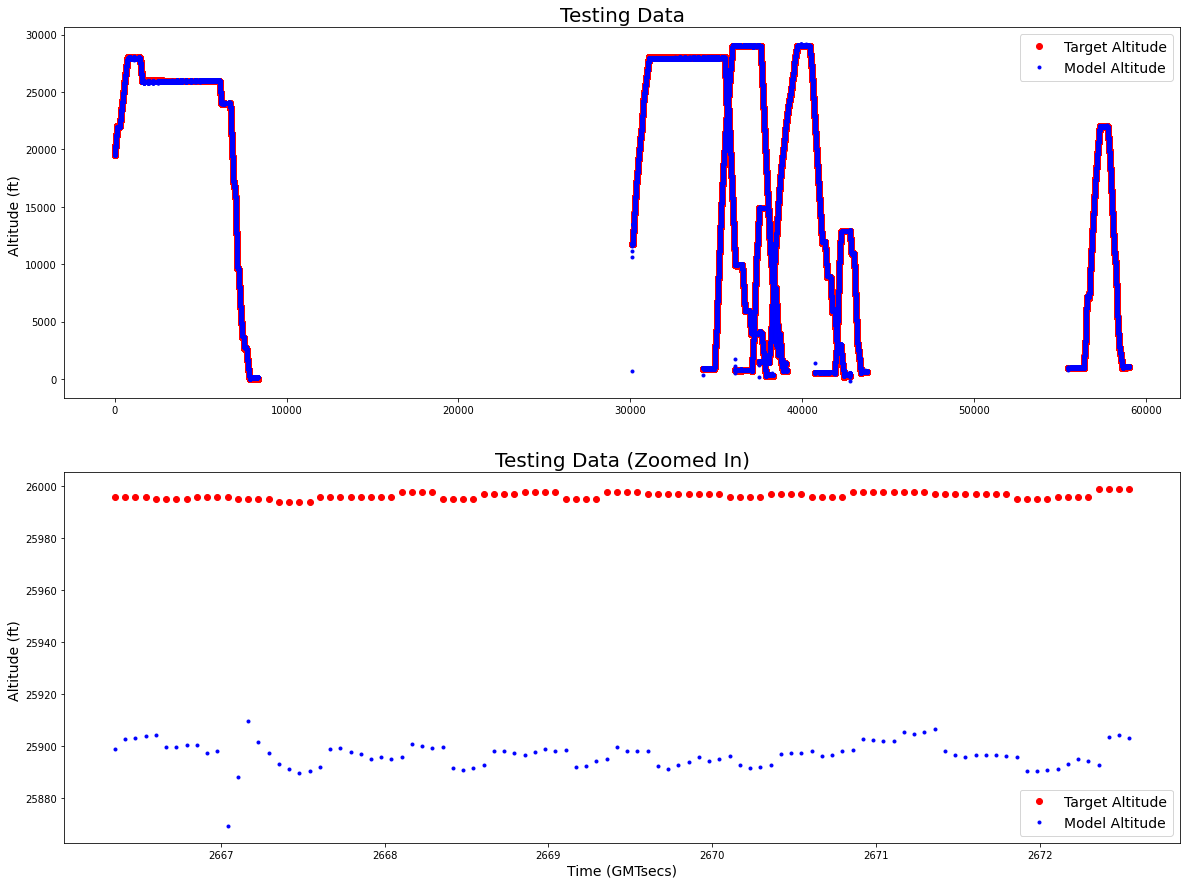

In [7]:
avg_error_train_list = []
avg_error_test_list  = []
    
print('All configurations trained and tested on "n_files".')
print('These files were randomly selected and this process was repeated for each configuration')
print(f'{n_rand_loops} times with the MSE being averaged over this repeated set training models.')
    
#loop through all the different configurations
for c in range(restart,len(seq_lengths)):
               
    seq_length = seq_lengths[c]
    learning_rate = l_rates[c]  
    n_epochs = epochs[c]
    hidden_units = n_h_units[c] 
    n_hidden_layers = n_h_layers[c]
    #n_files = n_f[c]
    
    print(f'\n\n\n----------------------\nConfiguration #{c}\n----------------------')
    print(f'seq_length:{seq_length}')
    print(f'learning_rate:{learning_rate}') 
    print(f'n_epochs:{n_epochs}')
    print(f'hidden_units:{hidden_units}') 
    print(f'n_hidden_layers:{n_hidden_layers}')
    print(f'n_bootloops:{n_rand_loops}')
    print(f'n_files:{n_files}\n-----------------')
    
                   
    ntrain = int((2/3)*n_files)
    ntest = n_files-ntrain
    
    
        
    avg_error_train=0
    avg_error_test=0
    #bootstrap loop
    for rf in range(n_rand_loops):
        
        start_training_time = time.time()
          
        #shuffle the files around in this list to get different results for the bootstrapping
        np.random.shuffle(file_list)    
        train_files = file_list[:ntrain]
        test_files  = file_list[ntrain:ntrain+ntest]
        
        # #print('Loading Data...')
        # Xtraindf, Ttraindf, Timetrain, scaleX, scaleT = \
        #     ndf.read_parquet_flight_merge(cwd, fdir, train_files, seq_length, scaleX=None, scaleT=None)
        #print('Loading Data...')
        Xtraindf, Ttraindf, Timetrain, scaleX, scaleT = \
            ndf.read_parquet_flight_merge(cwd, fdir, train_files, seq_length, scaleX=None, \
                                          scaleT=None, VRTG=True)
        
        
        ## Training
        #----------------------------------

        #varibles described at the beginning of this notebook.
        #number of samples, samples per sequence, components per sample
        N, S, I = Xtraindf.shape 
        O = Ttraindf.shape[1]
        n_input = I
        n_out = O

        #calling the LSTM definition above and initializing the model
        model = ml.LSTM(n_input, n_out, hidden_units, n_hidden_layers, device)
        #set computational resource to the "device"
        model = model.to(device)

        #Define the loss function used to calculate the difference between the model output and the training Target
        loss_func = torch.nn.MSELoss()
        
        #optimization function
        opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        error_trace = []


        #training the model
        #print('Training the Model...')
        for epoch in range(n_epochs):
            
            for i, (X, T) in enumerate(ndf.get_batch(Xtraindf, Ttraindf, batch_size=batch_size)):

                
                #create tensors from the data frames
                Xtrain = torch.from_numpy(X.astype(np.float32)).to(device)
                Ttrain = torch.from_numpy(T.astype(np.float32)).to(device)

                ##run input forward through model  
                #train_output = model(X)
                train_output = model(Xtrain)

                #zero out gradients of optimized torch.Tensors to zero before back-propagation happens
                opt.zero_grad()

                #calculate the loss of the model output (Y) to the training Target (Ttrain)
                #loss = loss_func(train_output, T)
                loss = loss_func(train_output, Ttrain)

                #back-propagation of the loss
                loss.backward()

                #performs a single optimization step (parameter update)
                opt.step()

                #keeping track of the history of the error in order to plot the convergence.
                error_trace.append(loss.detach().cpu().item())

                ##print progress when the modulus of epoch = 500
                #if epoch % 500 == 0:
                    #print(f'Epoch: {epoch:d}, loss: {loss.item():.8f}')

        
        end_training_time = time.time()
        model_train_time = end_training_time - start_training_time
        
        #number of batches that divided up the training set.
        n_train_batches = i+1
        
        train_loss = loss_func(train_output, Ttrain).detach().cpu()
        avg_error_train += train_loss.item()
        
        #print('after epoch loop')
        #!nvidia-smi
        
        del Xtrain, Ttrain, train_output
        torch.cuda.empty_cache()
        #print('after epoch loop delete')
        #!nvidia-smi
               
        #testing the model    
        #--------------------------
        #print('Testing the Model...')
        # Xtestdf, Ttestdf, Timetest, scaleX, scaleT = \
        #     ndf.read_parquet_flight_merge(cwd, fdir, test_files, seq_length, scaleX=scaleX, scaleT=scaleT)
        Xtestdf, Ttestdf, Timetest, scaleX, scaleT = \
            ndf.read_parquet_flight_merge(cwd, fdir, test_files, seq_length, scaleX=scaleX, \
                                          scaleT=scaleT, VRTG=True)
        #create tensors from the data frames
        Xtest = torch.from_numpy(Xtestdf.astype(np.float32)).to(device)
        Ttest = torch.from_numpy(Ttestdf.astype(np.float32)).to(device)
        
        #Run the test data through the trained model
        #timing the test
        start_time = time.time()
        test_output = model(Xtest)
        total_time = time.time() - start_time
        total_points = np.size(Xtestdf)
        #processing time per 1 second of real time
        unit_processing = total_time/(total_points/frequency)
        
        #calculate the loss of the model output (Y) to the training Target (Ttrain)
        loss = loss_func(test_output, Ttest).detach().cpu()       
    
        avg_error_test += loss.item()
        
        #file name
        model_name = f'{base_name}_config{c}_bootloop{rf}.pt'
        
        #Save model as is without the model card info to get minimum size
        torch.save(model, model_name)
        
        #opening the model file and measuring the size in memory
        start_mem = torch.cuda.memory_allocated(device=device)
        m = torch.load(model_name, map_location=device)
        end_mem = torch.cuda.memory_allocated(device=device)
        
        model_memory = end_mem - start_mem
        
        del m
        torch.cuda.empty_cache()
        
        #saving the model card data
        model.seq_length = seq_length
        model.learning_rate = learning_rate
        model.n_epochs = n_epochs
        model.approach = "Base+removeVar"
        
        #data to help start retraining model
        model.optimizer_state_dict = opt.state_dict() #saving the dictionary since i don't think the object will save
        model.model_state_dict = model.state_dict()
        model.loss = loss
        
        model.train_files = train_files
        model.test_files = test_files
        model.batch_size = batch_size
        model.n_train_batches = n_train_batches
        model.n_bootloops = n_rand_loops

        model.test_mse = loss.item()
        model.train_mse = train_loss.item()

        model.nfiles = n_files
        model.error_trace = error_trace

        model.scaleX = scaleX
        model.scaleT = scaleT
        model.device_name = device_properties.name
        model.device_major = device_properties.major
        model.device_minor = device_properties.minor
        model.device_total_memory = device_properties.total_memory
        model.device_multiprocessor_count = device_properties.multi_processor_count
                
        model.unit_processing = unit_processing
        model.model_train_time = model_train_time 
        model.model_size = model_memory
        
        #removing the scaling factor to plot in real units
        Ttest_alt = scaleT.inverse_transform(Ttestdf)
        Ytest_alt = scaleT.inverse_transform(test_output.detach().cpu().numpy())
        
        #tracking the error between the model output and target in real units (ft)
        err_alt = Ttest_alt - Ytest_alt
        model.test_err_mean = err_alt.mean()
        model.test_err_max  = err_alt.max()
        model.test_err_min  = min(abs(err_alt))[0]
        model.test_err_std  = err_alt.std()
        model.Ttest_alt     = Ttest_alt
        model.Ytest_alt     = Ytest_alt
        

        # save
        torch.save(model, model_name)
        
        
        del Xtest, Ttest, test_output, loss
        torch.cuda.empty_cache()
        #print('after test delete')
        #!nvidia-smi

    
    #calculating error over all the random runs
    avg_error_train = avg_error_train/n_rand_loops
    avg_error_train_list.append(avg_error_train)
    avg_error_test = avg_error_test/n_rand_loops
    avg_error_test_list.append(avg_error_test)
    

    #open up all bootloop models and save averages to them.
    best_mse = np.inf
    for rf in range(n_rand_loops):
        #file name
        model_name = f'{base_name}_config{c}_bootloop{rf}.pt'
        
        #opening the model file and measuring the size in memory
        #the more model card info I add the larger this file gets.
        #it may be a good idea to measure pure model vs model+modelcard
        start_mem = torch.cuda.memory_allocated(device=device)
        m = torch.load(model_name, map_location=device)
        end_mem = torch.cuda.memory_allocated(device=device)
        
        model_memory = end_mem - start_mem
        
        m.bootloop_avg_test_mse = avg_error_test
        m.bootloop_avg_train_mse = avg_error_train
        m.model_size_wcard = model_memory
        
        #keep the model with lowest individual mse for plotting later
        if m.test_mse < best_mse: 
            model = m
            best_bootloop_model = model_name
            
    
    
    print(f'Best Bootloop model: {best_bootloop_model}\nMSE: {model.test_mse}')
    del m
    torch.cuda.empty_cache()
    
    #run full set of the last training data through the best model to plot it
    Xtest = torch.from_numpy(Xtestdf.astype(np.float32)).to(device)
    test_output = model(Xtest)
    
    #removing the scaling factor to plot in real units
    Ttest_alt = scaleT.inverse_transform(Ttestdf)
    Ytest_alt = scaleT.inverse_transform(test_output.detach().cpu().numpy())
    
    
    
        
    #free up some GPU memory by deleting the tensors on the GPU
    del test_output, Ttestdf, Xtest, Xtestdf
    torch.cuda.empty_cache()  
    
    #print('after test_alt delete')
    #!nvidia-smi
       
    #run full set of the last training data through model to plot it
    Xtrain = torch.from_numpy(Xtraindf.astype(np.float32)).to(device)
    train_output = model(Xtrain)
    
    #removing the scaling factor to plot training and testing data in real units
    Ttrain_alt = scaleT.inverse_transform(Ttraindf)
    Ytrain_alt = scaleT.inverse_transform(train_output.detach().cpu().numpy())
    
    #free up some GPU memory by deleting the tensors on the GPU
    del Xtrain, train_output, Xtraindf, Ttraindf
    torch.cuda.empty_cache()   
    
    #file name
    model_name = f'{base_name}_config{c}_bootloop{rf}_best.pt'

    # save
    torch.save(model, model_name)
    
    
    #print('after train_alt delete')
    #!nvidia-smi
    
    #----------------------------------------------------------------------------------
    #plotting training convergence
    #-------------------------------
     
    print(f'---------------')    
    print(f'\n\nAverage Training Error: {avg_error_train:.9f}')
    print(f'Average Testing Error: {avg_error_test:.9f}')

    fig = plt.figure(figsize=(20, 8))
    plt.semilogy(error_trace[::21], '-b')
    ax1 = plt.gca()
    ax1.set_title('Training Error Convergence', fontsize=20)
    plt.ylabel('MSE Loss ',fontsize=14)
    plt.xlabel('# of Epochs',fontsize=14);
    plt.grid(visible=True, which='major', color='k', linestyle='-')
    plt.grid(visible=True, which='minor', color='0.9', linestyle='-')
    #plt.xlim(0,n_epochs)
    plt.ylim(0.0000001,1)
    plt.show();
    
    #plotting Training Data
    #----------------------
    fig = plt.figure(figsize=(20, 15))
    #fig.suptitle('Model vs Data',fontsize=20)

    #number of vertical subplots
    nv = 2

    #subplot 1
    ax1 = plt.subplot(nv,1,1)
    ax1.set_title('Training Data', fontsize=20)
    #plt.plot(Ttrain.detach().numpy()[42000:43000],      'ro', label='Target Altitude')
    plt.plot(Timetrain, Ttrain_alt, 'ro', label='Target Altitude')
    plt.plot(Timetrain, Ytrain_alt, 'b.', label='Model Altitude')
    plt.legend(fontsize=14)
    plt.ylabel('Altitude (ft) ',fontsize=14)

    #subplot 2
    istart = 42500
    istop  = 42600

    ax2 = plt.subplot(nv,1,2)
    ax2.set_title('Training Data (Zoomed In)', fontsize=20)
    plt.plot(Timetrain[istart:istop], Ttrain_alt[istart:istop], 'ro', label='Target Altitude')
    plt.plot(Timetrain[istart:istop], Ytrain_alt[istart:istop], 'b.', label='Model Altitude')
    plt.legend(fontsize=14)
    plt.ylabel('Altitude (ft) ',fontsize=14)

    plt.xlabel('Time (GMTsecs)',fontsize=14);
    plt.show();
               
    #plotting Testing Data
    #----------------------
    fig = plt.figure(figsize=(20, 15))
    #fig.suptitle('Model vs Test Data',fontsize=20)

    #number of vertical subplots
    nv = 2

    #subplot 1
    ax1 = plt.subplot(nv,1,1)
    ax1.set_title('Testing Data', fontsize=20)
    plt.plot(Timetest, Ttest_alt, 'ro', label='Target Altitude')
    plt.plot(Timetest, Ytest_alt, 'b.', label='Model Altitude')
    plt.legend(fontsize=14)
    plt.ylabel('Altitude (ft) ',fontsize=14)

    #subplot 2
    istart = 42500
    istop  = 42600

    ax2 = plt.subplot(nv,1,2)
    ax2.set_title('Testing Data (Zoomed In)', fontsize=20)
    plt.plot(Timetest[istart:istop], Ttest_alt[istart:istop], 'ro', label='Target Altitude')
    plt.plot(Timetest[istart:istop], Ytest_alt[istart:istop], 'b.', label='Model Altitude')
    plt.legend(fontsize=14)
    plt.ylabel('Altitude (ft) ',fontsize=14)

    plt.xlabel('Time (GMTsecs)',fontsize=14);
    plt.show();

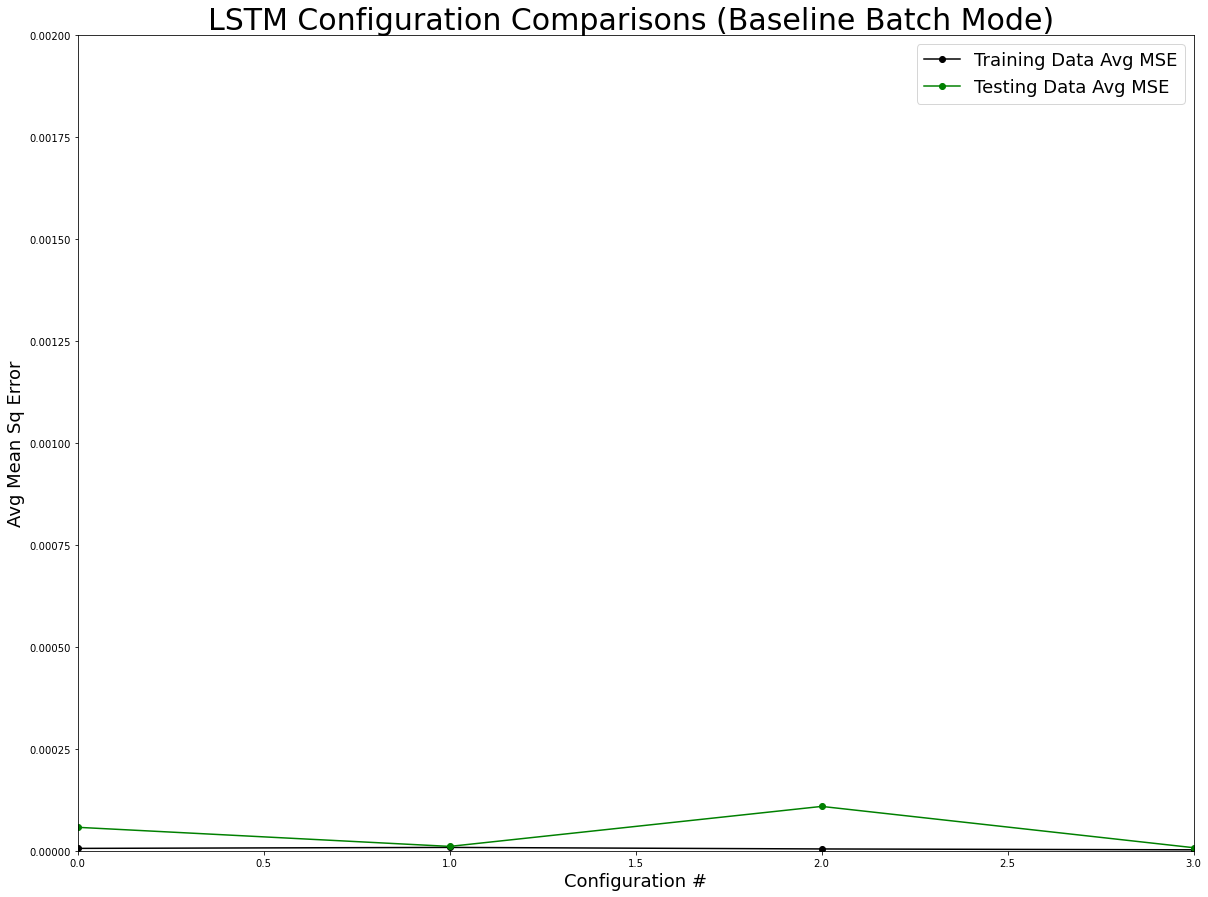

In [8]:
fig = plt.figure(figsize=(20, 15))
plt.plot(avg_error_train_list,'ko-',label='Training Data Avg MSE')
plt.plot(avg_error_test_list, 'go-',label='Testing Data Avg MSE')
ax = plt.gca()
ax.set_title('LSTM Configuration Comparisons (Baseline Batch Mode) ',fontsize=30)
plt.xlabel('Configuration #',fontsize=18)
plt.ylabel('Avg Mean Sq Error',fontsize=18)
plt.xlim(0,3)
plt.ylim(0,0.002)
plt.legend(fontsize=18);


In [9]:
avg_error_train_list, avg_error_test_list

([5.905959634825801e-06,
  8.305813044747387e-06,
  4.543221696925078e-06,
  2.441265413229606e-06,
  1.2985213781272857e-06,
  4.262261654730537e-06],
 [5.76211544588053e-05,
  1.0777414596911209e-05,
  0.00010888268002418044,
  7.584998760042557e-06,
  6.5635657999033965e-06,
  6.6981626029397985e-06])

# Configs 0-5
([8.38764020348511e-05,
  5.905959634825801e-06,
  8.305813044747387e-06,
  4.543221696925078e-06,
  2.441265413229606e-06,
  1.2985213781272857e-06,
  4.262261654730537e-06],
 [0.0004259429418501289,
  5.76211544588053e-05,
  1.0777414596911209e-05,
  0.00010888268002418044,
  7.584998760042557e-06,
  6.5635657999033965e-06,
  6.6981626029397985e-06])
